# Exercício 4 - Aplicação de redes neurais

Jean Carlos Mello Xavier Faria - 11259628

Leonardo Alves Amaral Torres   - 11261002

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy

In [2]:
input_size  = 28*28   # imagens com 28x28 pixels
output_size = 10      # 10 classes

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

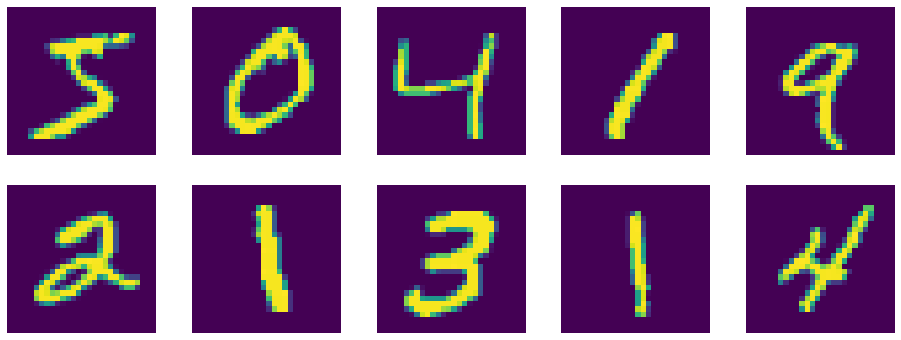

In [3]:
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');

In [4]:
class MLP(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, output_size), 
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)

In [5]:
class CNN(nn.Module):
    def __init__(self, n_feature):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)        
        x = self.conv2(x)
        x = F.relu(x)
        
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
accuracy_list = []

# Função para retornar o número de parâmetros de um modelo
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

def train(epoch, model):
    # Coloca o modelo em modo de treinamento
    model.train()
    
    # Loop sobre os mini-batches, fornecidos pelo DataLoader train_loader
    for batch_idx, (data, target) in enumerate(train_loader):      
        # Para mandar os dados para o device (GPU ou CPU definido anteriormente), usamos o método .to(device)
        data, target = data.to(device), target.to(device)
        
        # Ajuste de dimensões
        data = data.view(-1, 1, 28, 28)

        # Necessário no PyTorch, para limpar o cache de gradientes acumulados
        optimizer.zero_grad()
        
        # Cálculo da saída
        output = model(data)
        
        # nll_loss é a função custo da entropia cruzada
        loss = F.nll_loss(output, target)
        # cálculo dos gradientes
        loss.backward()
        # atualização dos parâmetros do modelo
        optimizer.step()
        
        # Exibe o status do treinamento
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model):
    # Coloca o modelo em modo de teste
    model.eval()
    
    # Variáveis usadas para contabilizar o valor da função custo e número de acertos
    test_loss = 0
    correct = 0
    
    # Loop sobre os mini-batches, fornecidos pelo DataLoader test_loader
    for data, target in test_loader:
        
        # Para mandar os dados para o device (GPU ou CPU definido anteriormente), usamos o método .to(device)     
        data, target = data.to(device), target.to(device)
        
        # Ajuste de dimensões
        data = data.view(-1, 1, 28, 28)
        
        # Cálculo da saída
        output = model(data)

        # Valor da função custo
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               

        # Cálculo do número de acertos
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    # Mostra o desempenho obtido no teste    
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

A modificação realizada para a rede MLP foi aumentar o número de neurônios da camada oculta, para 20. Além disso, foi utilizado o otimizador de Adam. A utilização do otimizador de Adam se deu ao fato de estarmos usando uma quantidade grande de dados, além de evitar a divergência ou estagnação do backpropagation.

In [21]:
# número de neurônios da camada oculta
n_hidden = 50

# Instanciando o modelo
model_fnn = MLP(input_size, n_hidden, output_size)

# Para mandar o modelo para o device (GPU ou CPU definido anteriormente), usamos o método .to(device)     
model_fnn.to(device)

# Definição do otimizador a ser utilizado. Aqui é usado o SGD, que usa o gradiente descendente com momentum
optimizer = optim.Adam(model_fnn.parameters(), lr=0.005)

# Mostra o número de parâmetros do modelo
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

# Loop das épocas de treinamento. Aqui é usada apenas 1 época.
for epoch in range(0, 1):
    train(epoch, model_fnn)
    test(model_fnn)

Number of parameters: 42310
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.285907
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.489709
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.293671
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.107887
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.129993
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.096052
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.219631
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.083588
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.163164
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.175158

Test set: Average loss: 0.1486, Accuracy: 9557/10000 (96%)



Para o caso da CNN, apenas foi mudado o otimizador, como no caso da MLP, foi utilizado o otimizador de Adam. Au

In [12]:
# Número de filtros das camadas convolucionais
n_features = 6

# Instanciando o modelo
model_cnn = CNN(n_features)

# Para mandar o modelo para o device (GPU ou CPU definido anteriormente), usamos o método .to(device)     
model_cnn.to(device)

# Definição do otimizador a ser utilizado. Aqui é usado o SGD, que usa o gradiente descendente com momentum
optimizer = optim.Adam(model_cnn.parameters(), lr=0.01)

# Mostra o número de parâmetros do modelo
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

# Loop das épocas de treinamento. Aqui é usada apenas 1 época.
for epoch in range(0, 1):
    train(epoch, model_cnn)
    test(model_cnn)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.284324
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.367853
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.058071
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.135294
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.182500
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.264537
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.250786
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.095612
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.016882
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.094270

Test set: Average loss: 0.0999, Accuracy: 9674/10000 (97%)

